In [1]:
# All Imports

import astra
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc


import tensorflow as tf
import numpy as np
#import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import SGD, RMSprop
import random
#from scipy.misc import imresize
import keras.backend as K
import copy


# GAN model

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, merge
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
#from scipy.misc import imsave
import scipy.stats
from skimage.measure import compare_ssim as ssim
import pydicom
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage import exposure
import glob
#from scipy.misc import imread
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_psnr
import numpy
from numpy.fft import fft2, ifft2, fftshift
import scipy.ndimage.interpolation as ndii

In [2]:
# [STAR] All the paths for training the model

projectionpath        = '/media/drilnvm/ubuntudata1/KnowledgeTransfer/TEMPORARY/NORMAL/'
highprojectionpath    = '/media/drilnvm/ubuntudata1/KnowledgeTransfer/TEMPORARY/TRIPLE/'
savepath              = '/media/drilnvm/ubuntudata1/KnowledgeTransfer/TEMPORARY/'


modelname = "normal-to-three-mse-0.9"

In [6]:
# [STAR] Helper functions for training the de-noising CNN


def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

# Get the breast region using otsu thresholding
def get_crop_image(lowimg, highimg):
    factor = 1
    
    #slice_index = random.randint(0, 24)
    #lowimg  = lowimg[slice_index]
    #highimg = highimg[slice_index]

    thresh  = threshold_otsu(lowimg)
    binary  = lowimg < thresh
    result  = np.multiply(binary, lowimg)

    rmin, rmax, cmin, cmax = bbox2(result)
    resultlowimg = result[rmin:rmax, cmin:cmax]
    resultlowimg = resultlowimg.astype(float)

    result        = np.multiply(binary, highimg)
    resulthighimg = result[rmin:rmax, cmin:cmax]
    resulthighimg = resulthighimg.astype(float)
    
    return resultlowimg, resulthighimg

# Extract Patches from the selected projection
def get_train_data_proj(lowimg, highimg, epoch, batch_size):
    highdose = []
    lowdose  = []
    cliplimit = 0
    
    imgshape = 256
    
    
    # loop till samples of size batch_size with atleast 90% occupancy is not obtained
    crop_count = 0
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    while(crop_count < batch_size):
        cropimgx = random.randint(1, rowst-imgshape)
        cropimgy = random.randint(1, colst-imgshape)
        
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov = np.sum(lowimg_crop > cliplimit)
        
        # atleast 90% occupancy should be there
        if nonzerov*1.0/(imgshape*imgshape) < 0.65:
            continue
        
        highimg_crop = highimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        #prob = random.randint(0, 100)
        #if prob < 50:
        #    lowimg_crop  = np.fliplr(lowimg_crop)
        #    highimg_crop = np.fliplr(highimg_crop)
        
        #lowimg_crop_mean  = np.mean(lowimg_crop.flatten())
        #highimg_crop_mean = np.mean(highimg_crop.flatten())
        #diff_mean         = highimg_crop_mean -  lowimg_crop_mean
        
        lowdose.append(lowimg_crop)
        highdose.append(highimg_crop)
        
        crop_count = crop_count+1
        
    return np.array(lowdose), np.array(highdose)

def mse(x, y):
    return np.linalg.norm(x - y)

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 200
    
    # Read the dicom file
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    
    cleanimage = np.zeros(limg.shape)
    
    thresh      = threshold_otsu(limg)
    binarymax   = limg > thresh
    
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    restimage   = binarymax#np.multiply(binarymax, limg)
    minvalue    = np.min(limg)
    
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    
    newbinary    = np.multiply(binary, binary1)
    result       = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/(thresh/2)
    lowimg       = resultlowimg-1
    
    #print(np.max(lowimg), np.mean(lowimg), np.min(lowimg), thresh)
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    halfvalue    = int(imgshape/2)
    quartervalue = int(imgshape/4)#+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            cleanimg    = cleanimg - (after_mean-before_mean)
            
            #print(np.mean(tempimg), np.mean(cleanimg))
            
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = cleanimg[0, :, :, 0][quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
            j = j+halfvalue
        i = i+halfvalue
    

    totalimage  = cleanimage+1
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    
    mul_result   = img_adapteq*(thresh/2)
    mul_result   = mul_result+minvalue
    tempvalue = np.min(mul_result)
    
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    
    # Convert to Dicom and save
    mul_result   = mul_result.astype(np.uint16)
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    
def test_on_whole_proj(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0.
    
    ds     = pydicom.dcmread(lowfilename)
    limg   = ds.pixel_array
    
    cleanimage = np.zeros(limg.shape)
    
    # get the histogram equalized image
    thresh      = threshold_otsu(limg)
    value_range = thresh - np.min(limg)
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    newbinary = np.multiply(binary, binary1)
    result    = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/thresh
    resultlowimg = exposure.equalize_adapthist(resultlowimg, clip_limit=cliplimit)
    lowimg       = resultlowimg
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    
    # For bottom row
    i = rowst-128
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    # For rightmost column
    j = colst-128
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # For leftmost column
    j = 0
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+128 < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            nonzerov     = np.sum(lowimg_crop >= cliplimit)
            
            # If it is not mostly occupied then don't process it
            if nonzerov*1.0/(128*128) < 0.9:
                cleanimage[i+64:i+128, j+64:j+128] = tempimg[32:96, 32:96]
                j = j+64
                continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            cleanimage[i+64:i+128, j+64:j+128] = cleanimg[0, :, :, 0][32:96, 32:96]
            j = j+64
        i = i+64
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    
    print('value range is ', value_range)
    mul_result   = img_adapteq*value_range
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    mul_result   = mul_result.astype(np.uint16)
    
    
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    max_value = np.max(mul_result)
    mul_result[mul_result == 0] = max_value*2
    
    #plt.hist(mul_result.flatten(), bins=256, range=(np.min(mul_result)+0.01, np.max(mul_result)), fc='k', ec='k')
    #plt.show()
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)

def test_on_whole_slice(lowfilename, highfilename, model, xindex, jindex):
    highdose = []
    lowdose  = []
    cliplimit = 0.03
    
    #projindex    = str(slicenum).zfill(2)+'.dcm'
    #lowfilename  = projectionpath+str(filenum)+'_20/_'+projindex
    #highfilename = highprojectionpath+str(filenum)+'_100/_'+projindex
    
    ds     = pydicom.dcmread(lowfilename)
    lowimg = ds.pixel_array
    
    ds      = pydicom.dcmread(highfilename)
    highimg = ds.pixel_array
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg, cliplimit)
    
    totalimage      = []
    totalimagereal  = []
    totalimagerealh = []
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    print('Shape of Image is ', rowst, 'x', colst)
    
    # Change the indexing later to accomodate the full image view
    # Or second option is to do the averaging at the corner views
    
    # count of processed rows in the whole image
    processed_count_total = 0
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    
    while(i+128 < rowst):
        # for clean image from model
        newrow      = []
        # for the real lowdose image
        newrowreal  = []
        # for the real highdose image
        newrowrealh = []
        # count of images processed in a row
        processed_count_row = 0
        # re-initialize the counter for j
        j = 0
        
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            tempimgh = highimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            newrowreal.append(tempimg[32:96, 32:96])
            newrowrealh.append(tempimgh[32:96, 32:96])
            
#             nonzerov = np.sum(lowimg_crop >= cliplimit)
#             # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(128*128) < 0.9:
#                 newrow.append(tempimg[32:96, 32:96])
#                 processed_count_row = processed_count_row+1
#                 continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            newrow.append(cleanimg[0, :, :, 0][32:96, 32:96])
            processed_count_row = processed_count_row+1
            
            if i  == (128*xindex) and j == (128*jindex):
                print('Clean Image SNR',    np.mean(cleanimg[0, :, :, 0])/np.std(cleanimg[0, :, :, 0]))
                print('Original Image SNR', np.mean(tempimg)/np.std(tempimg))
                print('HIGH Original Image SNR', np.mean(tempimgh)/np.std(tempimgh))
                
                ssim_low   = ssim(tempimgh, tempimg, data_range=tempimg.max() - tempimg.min())
                ssim_clean = ssim(tempimgh, cleanimg[0, :, :, 0], data_range=cleanimg[0, :, :, 0].max() - cleanimg[0, :, :, 0].min())
                
                print('SSIM low ',   ssim_low)
                print('SSIM clean ', ssim_clean)
                
                mse_clean   = mse(tempimgh, cleanimg[0, :, :, 0])
                mse_low     = mse(tempimgh, tempimg)
                
                print('MSE low ',   mse_low)
                print('MSE clean ', mse_clean)
                
                imsave('testimage.jpg', tempimg)
                imsave('clean2.jpg', cleanimg[0, :, :, 0])
                imsave('low2.jpg',   tempimg)
                imsave('high2.jpg',  tempimgh)
            j = j+64
        i = i+64
                
        combined = np.array(newrow)
        #print('newrow length is ', len(newrow), combined.shape)
        
        combined = np.hstack(combined.reshape(processed_count_row, 64, 64))
        totalimage.append(combined)
        
        combinedreal = np.array(newrowreal)
        combinedreal = np.hstack(combinedreal.reshape(processed_count_row, 64, 64))
        totalimagereal.append(combinedreal)
        
        combinedrealh = np.array(newrowrealh)
        combinedrealh = np.hstack(combinedrealh.reshape(processed_count_row, 64, 64))
        totalimagerealh.append(combinedrealh)
        
        # increment the rows processed count
        processed_count_total = processed_count_total+1
        
        #print('Shape of the combined image is ', combined.shape)
    
    totalimage = np.array(totalimage)
    totalimage = np.vstack(totalimage.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagereal = np.array(totalimagereal)
    totalimagereal = np.vstack(totalimagereal.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagerealh = np.array(totalimagerealh)
    totalimagerealh = np.vstack(totalimagerealh.reshape(processed_count_total, 64, processed_count_row*64))
    
    return totalimage, totalimagereal, totalimagerealh

image_indexes_result      = []
temp_image_indexes_result = []

# Store the images after training for few epochs
# use these images to see if model is performing well
def store_results(epoch, saveseed=5):
    global image_indexes_result
    global temp_image_indexes_result
    
    imgshape = 256
    
    # set the ids for saving the results
    random.seed(saveseed)
    
    projindex    = 1
    lowfilename  = projectionpath+'3584x1600x25.'+str(projindex)+'.raw'
    highfilename = highprojectionpath+'3584x1600x25.'+str(projindex)+'.raw'
    
    lowimg  = np.fromfile(lowfilename, dtype='float32')
    highimg = np.fromfile(highfilename, dtype='float32')
    lowvol  = np.reshape(lowimg, [25, 1600, 3584])/1250.0
    highvol = np.reshape(highimg, [25, 1600, 3584])/3750.0
    
    slice_index = 12#random.randint(0, 24)
    lowimg      = lowvol[slice_index]
    highimg     = highvol[slice_index]
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg)
    
    r, c = 6, 6
    x, y = get_train_data_proj(lowimg, highimg, 1, 128)
    x = x-0.5
    y = y-0.5
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95)
    plt.tight_layout()
    fig, axs = plt.subplots(r, c, figsize=(30,10))
    cnt      = 0
    
    for i in range(r):
        for j in range(c):
            if len(image_indexes_result) == 0:
                imgindex = random.randint(1, 127)
                temp_image_indexes_result.append(imgindex)
            else:
                imgindex = image_indexes_result[cnt]
            
            cleanimg = aae.generator.predict(np.expand_dims([x[imgindex]], axis=3))
            combined = np.array([x[imgindex]+0.5, cleanimg[0, :, :, 0]+0.5, y[imgindex]+0.5])
            combined = np.hstack(combined.reshape(3,imgshape,imgshape))
            #print(cleanimg[0, :, :, 0].shape, y[imgindex].shape, combined.shape)
            axs[i,j].imshow(combined, cmap='gray')
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i,j].axis('off')
            cnt += 1
    if len(image_indexes_result) == 0:
        image_indexes_result = temp_image_indexes_result
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig(savepath+modelname+"-results/clean_%d.png" % epoch, bbox_inches='tight')
    plt.close()

In [4]:
# [STAR] Model for training the de-noising network

img_shape  = (256, 256, 1)

def huber_loss(y_true, y_pred, clip_delta=0.04):
    error        = y_true - y_pred
    cond         = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

class AdversarialAutoencoder():
    def __init__(self):
        self.optimizer1  = RMSprop(0.0005)
        self.optimizer2  = RMSprop(0.00001)
        
        self.clip_value = 0.01
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        
        
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/vanilla-gan-weights-mse-0.1/discriminator_weights_8050.h5')
        self.d_arr = []
        self.g_arr = []
        
        # Build the encoder / decoder
        self.generator = self.build_generator()
         
        img = Input(shape=img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        reconstructed_img            = self.generator(img)
        #self.adversarial_autoencoder = Model(img, reconstructed_img)
        #self.adversarial_autoencoder.compile()
        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator determines validity of the cleaned image
        validity = self.discriminator(reconstructed_img)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        # Change it to avoid confusion
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'mse'],
            loss_weights=[0.9, 0.1],
            optimizer=self.optimizer2)
        
        self.discriminator.trainable = True
        self.discriminator.compile(loss='mse',
            optimizer=self.optimizer1, 
            metrics=['accuracy'])
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/discriminator_weights_8400.h5')
        #self.generator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/generator_weights_8400.h5')

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_autoencoder(self):
        self.generator.compile(loss=['mse'],optimizer=self.optimizer)
     
    def build_generator(self):
        x = Input(shape=img_shape)
        x1 = Conv2D(32, (3, 3), padding='same')(x)
        x1 = LeakyReLU(alpha=0.2)(x1)
        
        x2 = Conv2D(64, (3, 3), padding='same')(x1)
        #x2 = BatchNormalization(momentum=0.8)(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        
        x3 = Conv2D(64, (3, 3), padding='same')(x2)
        #x3 = BatchNormalization(momentum=0.8)(x3)
        x3 = LeakyReLU(alpha=0.2)(x3)
        
        #x3_m = merge([x2, x3], mode='concat', concat_axis=3)
        x4 = Conv2D(64, (3, 3), padding='same')(x3)
        #x4 = BatchNormalization(momentum=0.8)(x4)
        x4 = LeakyReLU(alpha=0.2)(x4)
        #x6_i = merge([x2, x6], mode='concat', concat_axis=3)
        
        
        x5 = Conv2D(128, (3, 3), padding='same')(x4)
        #x5 = BatchNormalization(momentum=0.8)(x5)
        x5 = LeakyReLU(alpha=0.2)(x5)
        
        #x7_i = merge([x1, x7], mode='concat', concat_axis=3)
        x6 = Conv2D(128, (3, 3), padding='same')(x5)
        x6 = LeakyReLU(alpha=0.2)(x6)
        
        x7 = Conv2D(64, (3, 3), padding='same')(x6)
        #x8 = BatchNormalization(momentum=0.8)(x8)
        x7 = LeakyReLU(alpha=0.2)(x7)
        #x7_m = merge([x1, x6], mode='concat', concat_axis=3)
        #x8    = Conv2D(1, (3, 3), activation='relu', padding='same')(x6)
        x8 = Conv2D(1, (3, 3), padding='same')(x7)
        x8 = LeakyReLU(alpha=0.2)(x8)
        
        out = keras.layers.Subtract()([x, x8])
        #out = ReLU()(out)
        model = Model(x, out)
        return model

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64,  (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        #         model.add(Conv2D(16, (6, 6),  strides=(2, 2)))
        #         model.add(LeakyReLU(alpha=0.2))
        #         model.add(Dropout(0.5))
        model.add(Conv2D(64, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Dense(1))
        return model
    
    def train_generator_autoencoder(self, epochs, batch_size=128):
        for epoch in range(epochs):
            # Load the dataset
            X_train, Y_train = get_train_data(epoch, batch_size)
            
            X_train = np.expand_dims(X_train, axis=3)
            Y_train = np.expand_dims(Y_train, axis=3)
            
            g_loss = self.generator.train_on_batch(X_train, Y_train)
            
            # Plot the progress
            print ("Epoch ", epoch, " G loss ", g_loss)
            if epoch%50 == 0:
                store_results(epoch)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
    
    def train(self, epochs, batch_size=128, sampling=50, saveseed=5, startepoch=0, discriminator_epochs=5):
        for epoch in range(startepoch, epochs):
            # Train the discriminator 5 times
            #print('Training Discriminator ', epoch)
            
            projindex = 1
            # Original
            #projindex = str(random.randint(43, 68))#+'.dcm'
            
            # File names of lowdose and highdose files
            lowfilename  = projectionpath+'3584x1600x25.'+str(projindex)+'.raw'
            highfilename = highprojectionpath+'3584x1600x25.'+str(projindex)+'.raw'
            
            # Read the lowdose and highdose files
            lowimg  = np.fromfile(lowfilename, dtype='float32')
            highimg = np.fromfile(highfilename, dtype='float32')
            
            # Convert to image shape
            # Normalize the data before training
            lowvol  = np.reshape(lowimg,  [25, 1600, 3584])/1250.0
            highvol = np.reshape(highimg, [25, 1600, 3584])/3750.0
            
            # Training the discriminator first
            for itd in range(discriminator_epochs):
                
                # Randomly select a projection
                slice_index = random.randint(0, 24)
                lowimg      = lowvol[slice_index]
                highimg     = highvol[slice_index]
                
                # get the cropped image
                lowimg, highimg =  get_crop_image(lowimg, highimg)
                
                # Load the dataset
                X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
                X_train = X_train - 0.5
                Y_train = Y_train - 0.5
                
                #print(X_train.shape, Y_train.shape)
                
                X_train = np.expand_dims(X_train, axis=3)
                Y_train = np.expand_dims(Y_train, axis=3)

                # Adversarial ground truths
                valid = np.ones((batch_size, 1))
                fake  = np.zeros((batch_size, 1))

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # get the noisy image and feed it into the generator
                X_train_clean = self.generator.predict(X_train)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(Y_train, valid)
                d_loss_fake = self.discriminator.train_on_batch(X_train_clean, fake)
                d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            
            # ---------------------
            #  Train Generator
            # ---------------------
            # Train the generator end-to-end 
            g_loss = self.adversarial_autoencoder.train_on_batch(X_train, [Y_train, valid])
            
            
            self.d_arr.append(d_loss)
            self.g_arr.append(g_loss)
            
            if epoch%sampling == 0:
                store_results(epoch, saveseed)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                #self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
            
            print ("%d [D loss: %f, mean_acc: %.2f%% real_acc: %.2f%% fake_acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss[2]*0.0001, g_loss[1]*0.999))

In [ ]:
# [STAR] Training loop of the model

aae = AdversarialAutoencoder()
aae.train(epochs=25000, batch_size=8, sampling=50, saveseed=0, startepoch=0)

In [ ]:
# [STAR] For denoising the projections of dicom files
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 256
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    cleanimage        = np.zeros(limg.shape)
    thresh            = threshold_otsu(limg)
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    binary  = limg <= thresh
    
    result       = np.multiply(binary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    lowimg       = resultlowimg
    
    # Perform sharpening before de-noising
    #lowimg = unsharp_mask(lowimg, radius=3, amount=0.5, preserve_range=True)
    
    print(np.min(resultlowimg.flatten()), np.max(resultlowimg.flatten()))
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx     = i
        cropimgy     = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        #cleanimg    = cleanimg*3750.0
        
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    halfvalue    = int(imgshape/2) # replacement size
    quartervalue = int(imgshape/4) # stride size 
    #+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 -0.5
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            #cleanimg    = cleanimg + before_mean
            cleanimg    = cleanimg - (after_mean-before_mean)
            #cleanimg[cleanimg < 0] = 0
            #print(after_mean, before_mean)
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = (cleanimg[0, :, :, 0]+0.5)[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]*1250
            #j = j+halfvalue
            j = j+quartervalue
        #i = i+halfvalue
        i = i+quartervalue
    
#     savename = lowfilename.split('/')[-1]
#     savepath = cleanprojpath+savename+'.npy'
#     np.save(savepath, cleanimage)
    
    #cleanimage[cleanimage < 0] = 0
    #cleanimage[cleanimage > 2000] = 2000
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq  = np.multiply(totalimage, binarynew)
    mul_result   = img_adapteq
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    mul_result[mul_result < 0] = 0
    print(np.min(mul_result.flatten()), np.max(mul_result.flatten()), mul_result.dtype, cleanimage.dtype, cleanimg.dtype)
    
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    
    mul_result   = mul_result.astype(np.uint16)
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('/')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    


lowprojpath   = '/media/drilnvm/ubuntudata2/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/'
cleanprojpath = '/media/drilnvm/ubuntudata2/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/CLEAN-PROJ/'

# Load the weights which look the best
aae = AdversarialAutoencoder()
aae.generator.load_weights('/media/drilnvm/ubuntudata1/KnowledgeTransfer/DBT-PROJ-DENOISE/gan-mse-0.9-weights/generator_weights_6950.h5')
#aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-0.99-weights/generator_weights_400.h5')

files = glob.glob(lowprojpath+'*.IMA')

for f in files:
    print(f)
    test_on_whole_proj_200(f, aae)
    
    
#tensorflow.keras.losses.Huber(delta=1.5)
#tf.keras.losses.

In [ ]:
# [STAR] For generating the projections

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)





# Geometry Settings
scaling_factor = 1

SOD       = 65/0.025
ODD       = 4.5/0.025
detWidth  = 0.0085/0.025 #/(0.0255/scaling_factor)   # size of each detector pixel
detHeight = detWidth        # size of each detector pixel
detRows   = 3584
detCols   = 1600


num_angles = 25


# Phantom Files
a       = sio.loadmat("/media/drilnvm/ubuntudata1/KnowledgeTransfer/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0

# Create Volume Geometry
vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')


print('Starting Recon')


# All Flags
recon_type       = 0
use_old_calci    = 0 # Use already generated calcifications
save_projections = 1 # Save the projections
insert_noise     = 1


triple_dose  = True
quarter_dose = False
normal_dose  = True

# SIRT iteration LOOP
if recon_type == 0:
    niter      = 10
    start_time = time.time()
    
    for index in range(1, 2):
        print("Phantom ", index)
        # Reading Phantom
        
        a       = sio.loadmat("/media/drilnvm/ubuntudata1/KnowledgeTransfer/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
        testvol = np.rollaxis(a, 2, 0)
        testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
        volume_mask = testvol > 0
        
        testvol = np.multiply(volume_mask, testvol)
        testvol = testvol/65.0
        
        # Change the angles here
        ang = []
        for i in range(num_angles):
            ang.append(1.9)
        start_angle = -25#+np.random.randint(0, 3)
        theta       = []
        for i in range(num_angles):
            theta.append(start_angle*np.pi/180.0)
            start_angle = start_angle+ang[i]
        
        vectors = np.zeros((len(theta), 12))
        
        # For reconstructing real data
        vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
        vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
        vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
        vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V

        # Creating the projection matrix
        proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
        proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
        W                = astra.OpTomo(proj_id)
        
        proj_arr         = W*testvol
        
        # Reshape the data to Image form
        temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
        temp_proj = np.rollaxis(temp_proj, 0, 2)
        
        
        if triple_dose:
            I0        = 6000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/drilnvm/ubuntudata1/KnowledgeTransfer/TEMPORARY/TRIPLE/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if normal_dose:
            I0        = 2000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/drilnvm/ubuntudata1/KnowledgeTransfer/TEMPORARY/NORMAL/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if(quarter_dose):
            I0        = 500
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            #np.array(proj_noi).astype('float32').tofile(fid)
            np.array(g_noi).astype('float32').tofile(fid)

In [8]:
a       = sio.loadmat("/media/drilnvm/ubuntudata1/KnowledgeTransfer/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0


print(testvol.shape)

(320, 448, 800)


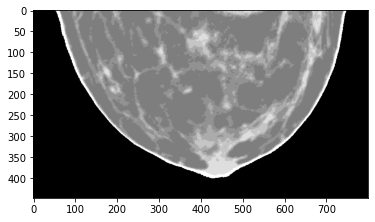

In [9]:
# z, x, y
plt.imshow(testvol[160], cmap='gray')

In [27]:
a       = np.fromfile('/home/drilnvm/Hailiang/uppaddle_3mm_pc_209923395_crop_1073x2748x860.raw', dtype='int8')
a       = np.reshape(a, [860, 2748, 1073]) 
testvol = []
for i in range(a.shape[0]):
    testvol.append(np.rot90(a[i, :, :], k=3))
testvol = np.array(testvol)

(860, 1073, 2748)


In [11]:
# [STAR] For generating the projections for Density Estimation work

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)





# Geometry Settings
scaling_factor = 1

SOD       = 65/0.005
ODD       = 4.5/0.005
detWidth  = 0.0085/0.005 #/(0.0255/scaling_factor)   # size of each detector pixel
detHeight = detWidth        # size of each detector pixel
detRows   = 3584
detCols   = 1600


num_angles = 25


# Phantom Files
a       = np.fromfile('/home/drilnvm/Hailiang/uppaddle_3mm_pc_209923395_crop_1073x2748x860.raw', dtype='int8')
a       = np.reshape(a, [860, 2748, 1073]) 
testvol = []
for i in range(a.shape[0]):
    testvol.append(np.rot90(a[i, :, :], k=3))
testvol = np.array(testvol)


# Create Volume Geometry
vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

save_projections = 1 # Save the projections

triple_dose  = True
quarter_dose = False
normal_dose  = True
start_time = time.time()


# Read Phantom
a       = np.fromfile('/home/drilnvm/Hailiang/uppaddle_3mm_pc_209923395_crop_1073x2748x860.raw', dtype='int8')
a       = np.reshape(a, [860, 2748, 1073]) 
testvol = []
for i in range(a.shape[0]):
    testvol.append(np.rot90(a[i, :, :], k=3))
testvol     = np.array(testvol)
volume_mask = testvol > 0
testvol = np.multiply(volume_mask, testvol)
                      

# Change the angles here
ang = []
for i in range(num_angles):
    ang.append(1.9)
start_angle = -25#+np.random.randint(0, 3)
theta       = []
for i in range(num_angles):
    theta.append(start_angle*np.pi/180.0)
    start_angle = start_angle+ang[i]

vectors = np.zeros((len(theta), 12))

# For reconstructing real data
vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD                          # S source to object
vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
#vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))          # U
#vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))          # V
vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta)), np.zeros(len(theta)), np.zeros(len(theta))]))          # U
vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta)), np.zeros(len(theta))]))          # V


# Creating the projection matrix
proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
W                = astra.OpTomo(proj_id)

proj_arr         = W*testvol

# Reshape the data to Image form
temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
temp_proj = np.rollaxis(temp_proj, 0, 2)

print(temp_proj.shape)
#fid = open('/media/drilnvm/ubuntudata1/KnowledgeTransfer/TEMPORARY/NORMAL/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
#np.array(proj_noi).astype('float32').tofile(fid)

(25, 1600, 3584)


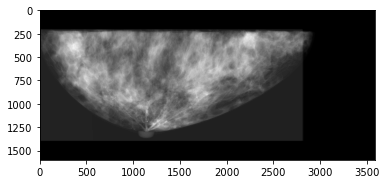

In [16]:
plt.imshow(temp_proj[24], cmap='gray')